# Snake

In [54]:
from environments import *
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
import json
from models import *
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [55]:
LOAD_FROM_MEMORY = False

## Environment definition

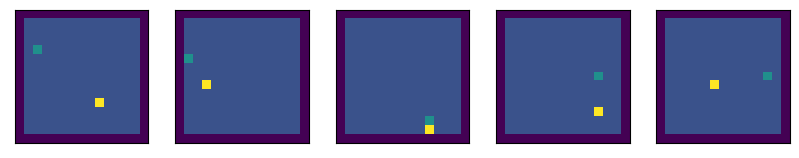

In [56]:
%matplotlib inline
def get_env(n=1000):
    return OriginalSnakeEnvironment(n, 15)
env_ = get_env()
# reward discount
GAMMA = .9
# number of iterations for the training (snake steps)
ITERATIONS = 5000
# Eps to add to the policy probabilities to ensure a bit of exploration
EPSILON = 0.1
# lambda parameters for value and policy wrt eligibility traces
LAMBDA_VALUE = 0.1
LAMBDA_AGENT = 0.1
# penalty to apply to masked probabilities
ALPHA = 10.
# percentage of boards to sample each time for the gradient estimation
# used to de-correlate gradients
PERCENTAGE_TO_HOLD = 0.9999

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Demo

In [57]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
demo_env = get_env(5)
def animate(_):
    original_probs = tf.convert_to_tensor([[.25]*4]*demo_env.n_boards)
    mask = get_probabilities_mask(demo_env.boards, original_probs.shape)
    probs = tf.linalg.normalize(original_probs * mask, ord=1, axis=-1)[0]
    actions = tf.random.categorical(tf.math.log(probs),1)
    demo_env.move(actions)
    for board, image in zip(demo_env.boards, images):
        image.set_data(board)
    return images

In [58]:
fig, axs = plt.subplots(1,demo_env.n_boards, figsize=(10,3))
images = []
for b, ax in zip(demo_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

## Model

In [59]:
MODELS_PREFIX = f"py/models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [60]:
agent, value, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

## Training

In [61]:
avg_td_error = []

In [62]:
agent, value, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

In [63]:
optimizer_value = K.optimizers.Adam(1e-4)
optimizer_agent = K.optimizers.Adam(1e-5)

 92%|█████████▏| 4599/5000 [11:09<00:58,  6.82it/s]

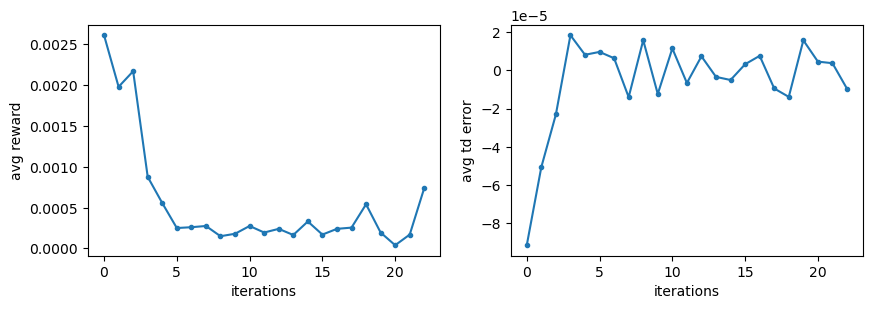

 96%|█████████▌| 4799/5000 [11:37<00:25,  7.73it/s]

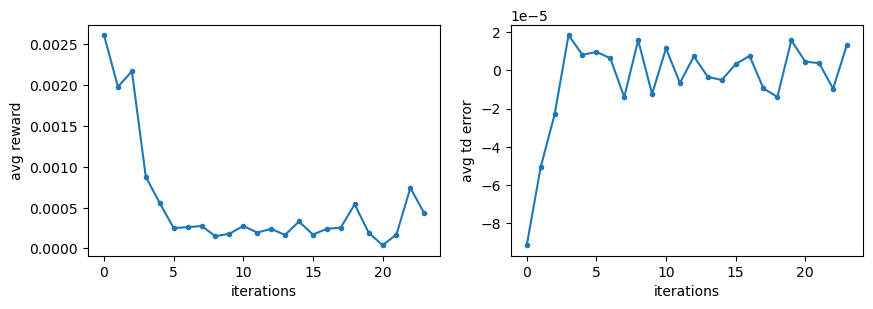

100%|█████████▉| 4999/5000 [12:04<00:00,  7.09it/s]

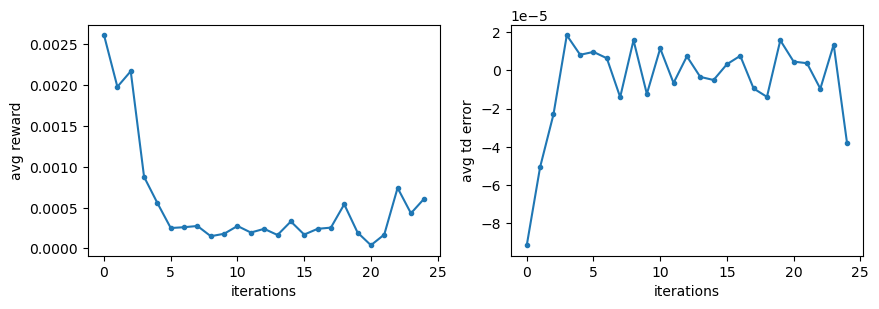

100%|██████████| 5000/5000 [12:05<00:00,  6.89it/s]


In [64]:
%matplotlib inline
eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
for _ in trange(ITERATIONS):
    state = env_.to_state()
    with tf.GradientTape(persistent=True) as tape:

        original_probs = agent(state)
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(original_probs)), 1, dtype=tf.int32)

        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        value_state = value(state)
        new_value_state = value(new_state)
        td_error = tf.stop_gradient((rewards + GAMMA * new_value_state) - value_state) * -1

        actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)
        loss_agent = tf.stop_gradient(td_error) * \
                     tf.math.log(1e-10 + tf.gather_nd(original_probs, actions_indexes))[..., None]
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)

    avg_td_error.append(tf.reduce_mean(td_error))
    avg_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

    if LAMBDA_AGENT > 1e-4 or LAMBDA_VALUE > 1e-4:
        gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
        gradient_value = tape.gradient(loss_value, value.trainable_weights)
        eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_agent, gradient_agent)]
        eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + gradient for layer, gradient in
                                   zip(eligibility_trace_value, gradient_value)]
        optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
        optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))
        del gradient_agent
        del gradient_value
    else:
        optimizer_value.minimize(loss_value, value.trainable_weights, tape=tape)
        optimizer_agent.minimize(loss_agent, agent.trainable_weights, tape=tape)

    # every N iterations, plot the avg reward of each chunk of 100 iterations, and save the models
    N = 200
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        # plot
        points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(avg_td_error).reshape((-1, N)).mean(axis=-1) * -1
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg td error")

        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training. txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        agent.save_weights(f"{MODELS_PREFIX}/agent")
        value.save_weights(f"{MODELS_PREFIX}/value")


### Random policy reward

In [65]:
random_env = get_env(1000)
random_rewards = []

for _ in trange(1000):
    original_probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(original_probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

100%|██████████| 1000/1000 [00:10<00:00, 95.69it/s]


## Training evaluation

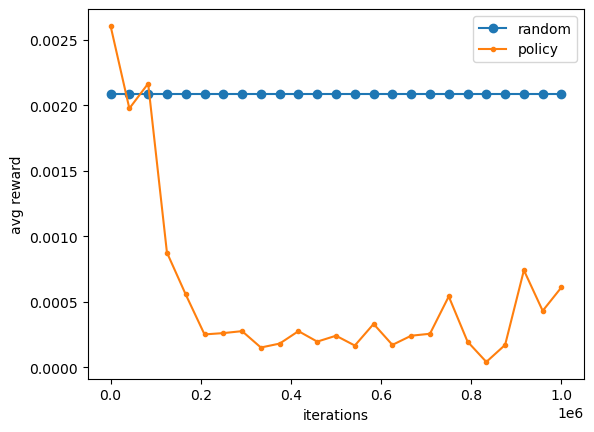

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

 ## Test (graphical simulation)

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [12]:
test_env = get_env(3)

In [13]:
def animate(_):
    original_probs = tf.concat((agent(
        test_env.to_state()
    )[:-1]+ EPSILON, [[.25]*4]), axis=0)

    actions = tf.random.categorical(tf.math.log(original_probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [14]:
# first three are policy guided, the fourth is random, to give a comparison
fig, axs = plt.subplots(1,3, figsize=(12,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>